# Test notebook for scirpy usage
This notebook is the analog to the Colab created by Gregor S. for the demonstration of scirpy.datasets function usage:

https://colab.research.google.com/drive/15HIYGsSBHkDV399KSchv2QEyBzheL6fW?usp=sharing


1. The databases (McPAS, VDJDB and IEDB) are merged in a BioCypher Knowledge Graph (KG)
2. The Knowledge Graph is converted to a list of AIRR cells via BioCypher
3. The list of AIRR cells is converted to AnnData using scirpy functionality 

Note: in order to run this notebook, please pip install the forked BioCypher repository with AIRR conversion implementation

In [1]:
import sys
sys.path.append('..')

import re
import requests
import time

import muon as mu
import numpy as np
import scanpy as sc
import pandas as pd
import scirpy as ir

from tqdm import tqdm

# from tcr_epitope.adapters.utils import AnnDataKG
# from biocypher.output.in_memory._airr_to_anndata import AIRRtoAnnDataKG as AnnDataKG

sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)

/home/lera/.cache/pypoetry/virtualenvs/tcr-epitope-cBadFBpD-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data import and preprocessing

In [2]:
mdata = ir.datasets.wu2020_3k()
ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)
mu.pp.filter_obs(mdata, "airr:chain_pairing", lambda x: ~np.isin(x, ["orphan VDJ", "orphan VJ", "multichain"]))

/home/lera/.cache/pypoetry/virtualenvs/tcr-epitope-cBadFBpD-py3.11/lib/python3.11/site-packages/anndata/utils.py:354: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)


Filtering chains...
Indexing VJ chains...


/home/lera/.cache/pypoetry/virtualenvs/tcr-epitope-cBadFBpD-py3.11/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/lera/.cache/pypoetry/virtualenvs/tcr-epitope-cBadFBpD-py3.11/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


Indexing VDJ chains...
build result array
Stored result in `mdata.obs["airr:receptor_type"]`.
Stored result in `mdata.obs["airr:receptor_subtype"]`.
Stored result in `mdata.obs["airr:chain_pairing"]`.


# Clonotype clustering

Computing sequence x sequence distance matrix for VJ sequences.
block size set to 50


100%|██████████| 496/496 [00:10<00:00, 45.52it/s] 

Computing sequence x sequence distance matrix for VDJ sequences.
block size set to 50



100%|██████████| 496/496 [00:04<00:00, 120.28it/s]


Initializing lookup tables. 
Computing clonotype x clonotype distances.
Stored result in `mdata.obs["airr:cc_aa_alignment"]`.
Stored result in `mdata.obs["airr:cc_aa_alignment_size"]`.


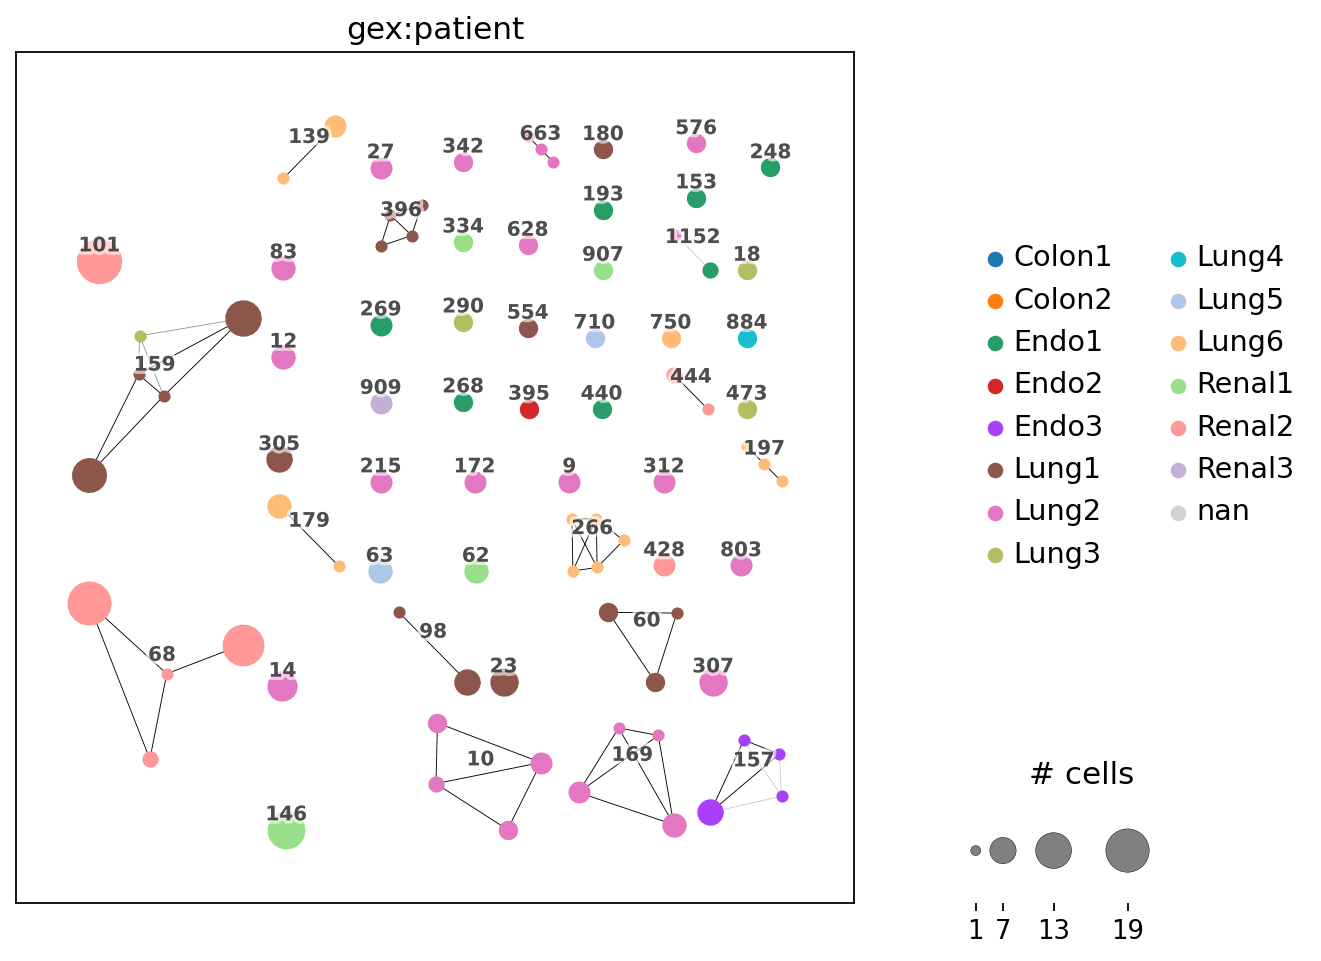

In [3]:
ir.pp.ir_dist(
    mdata,
    metric="alignment",
    sequence="aa",
    cutoff=15)

ir.tl.define_clonotype_clusters(mdata,
                                sequence="aa",
                                metric="alignment",
                                receptor_arms="all",
                                dual_ir="any")

#min_cells = 3 will only plot clonotype clusters with a size >= 3
ir.tl.clonotype_network(mdata, min_cells=3, sequence="aa", metric="alignment")

_ = ir.pl.clonotype_network(mdata, color="gex:patient", label_fontsize=9, panel_size=(7, 7), base_size=20)

# save figure as a png
#plt.savefig("clonotype_network.png", bbox_inches="tight")

# Load merged BioCypher data: list of AIRR cells

In [4]:
import gzip
import json

import scirpy as ir

from datetime import datetime
from typing import List, Dict, Any
from scirpy.io._datastructures import AirrCell
from scirpy.io._convert_anndata import from_airr_cells
from scirpy.pp import index_chains

In [5]:
def load_airr_cells_from_json(json_file_path: str, cell_attribute_fields: tuple = ()) -> List[AirrCell]:
    """
    Load AirrCell objects from a JSON file.
    
    Parameters
    ----------
    json_file_path : str
        Path to the JSON file containing serialized AirrCell data
    cell_attribute_fields : tuple, optional
        List of field names that should be stored at cell level
        
    Returns
    -------
    List[AirrCell]
        List of reconstructed AirrCell objects
    """
    
    # Load JSON data
    with gzip.open(json_file_path, 'rt', encoding='utf-8') as f:
        airr_data = json.load(f)
    
    airr_cells = []
    
    for cell_data in airr_data:
        # Extract cell_id from the data
        cell_id = cell_data['cell_id']
        
        # Create new AirrCell instance
        airr_cell = AirrCell(
            cell_id=cell_id,
            cell_attribute_fields=cell_attribute_fields
        )
        
        # Add cell-level attributes
        if 'cell_attributes' in cell_data:
            for key, value in cell_data['cell_attributes'].items():
                if key != 'cell_id':  # cell_id is already set in constructor
                    airr_cell[key] = value
        
        # Add chains
        if 'chains' in cell_data:
            for chain in cell_data['chains']:
                airr_cell.add_chain(chain)
        
        airr_cells.append(airr_cell)
    
    return airr_cells

In [ ]:
# Convert list of AIRR cells to AnnData
filename = "airr_cells_test.json.gz"
airr_cells = load_airr_cells_from_json(filename)
adata = from_airr_cells(airr_cells)
index_chains(adata)

adata.uns["DB"] = {"name": "BioCyphwe", "date_downloaded": datetime.now().isoformat()}

# # store cache
# os.makedirs(os.path.dirname(os.path.abspath(cache_path)), exist_ok=True)
# adata.write_h5ad(cast(os.PathLike, cache_path))file

Filtering chains...
Indexing VJ chains...
Indexing VDJ chains...
build result array


In [7]:
ir.get.airr(adata, airr_variable = ["v_call","j_call", "junction_aa"], chain = ["VDJ_1"]).head(5)

,VDJ_1_v_call,VDJ_1_j_call,VDJ_1_junction_aa
cell_id,,,
tra:CALSEEPSGSRLTF:TRAV19-trb:CASSQQDRLADTQYF:TRBV4-2,TRBV4-2,TRBJ2-3,CASSQQDRLADTQYF
tra:CAMREDTGGSYIPTF:TRAV14/DV4-trb:CASSPDRRQETQYF:TRBV7-9,TRBV7-9,TRBJ2-5,CASSPDRRQETQYF
tra:CATGKAAGNKLTF:TRAV17-trb:CASSQVPTSGNEQFF:TRBV4-1,TRBV4-1,TRBJ2-1,CASSQVPTSGNEQFF
tra:CALKHNNARLMF:TRAV19-trb:CASSPLAGVSDTQYF:TRBV7-6,TRBV7-6,TRBJ2-3,CASSPLAGVSDTQYF
tra:CAAVTNFGNEKLTF:TRAV23/DV6-trb:CASSSRPGLAGYWVDTQYF:TRBV6-6,TRBV6-6,TRBJ2-3,CASSSRPGLAGYWVDTQYF


Index(['MHC_class', 'MHC_gene_1', 'MHC_gene_2', 'PMID', 'antigen_name',
       'antigen_species', 'data_source', 'epitope_sequence', 'iedb_iri',
       'is_paired', 'VDJ_1_j_call'],
      dtype='object')


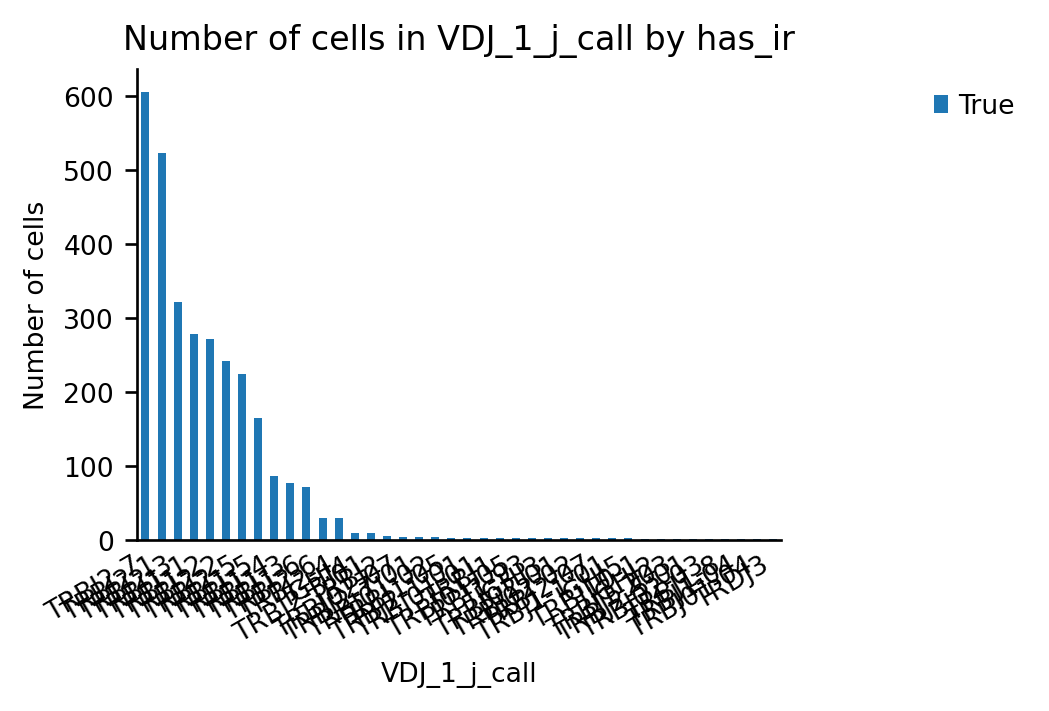

In [8]:
with ir.get.airr_context(adata, "j_call", "VDJ_1"):
    print(adata.obs.columns)
    _= ir.pl.group_abundance(adata, groupby="VDJ_1_j_call", max_cols = 0)
    # plt.xticks(rotation=50, ha='right')

In [9]:
ir.pp.ir_dist(mdata, adata, metric="fastalignment", sequence="aa", cutoff = 10)

Computing sequence x sequence distance matrix for VJ sequences.
block size set to 50


100%|██████████| 961/961 [00:00<00:00, 1020.15it/s]

Computing sequence x sequence distance matrix for VDJ sequences.
block size set to 71



100%|██████████| 1012/1012 [00:01<00:00, 549.30it/s]


In [10]:
ir.tl.ir_query(
    mdata,
    adata,
    metric="fastalignment",
    sequence="aa",
    receptor_arms="VDJ",
    dual_ir="primary_only",
)

Initializing lookup tables. 
Computing clonotype x clonotype distances.
Stored IR distance matrix in `adata.uns["ir_query_BioCyphwe_aa_fastalignment"]`.


In [11]:
ir.tl.ir_query_annotate(
    mdata,
    adata,
    metric="fastalignment",
    sequence="aa",
    strategy = "most-frequent",
    include_ref_cols=["antigen_name"],
)

  0%|          | 0/289 [00:00<?, ?it/s]/home/lera/.cache/pypoetry/virtualenvs/tcr-epitope-cBadFBpD-py3.11/lib/python3.11/site-packages/scirpy/tl/_ir_query.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return values[0]
100%|██████████| 289/289 [00:00<00:00, 3737.22it/s]

Stored result in `mdata.obs["airr:antigen_name"]`.


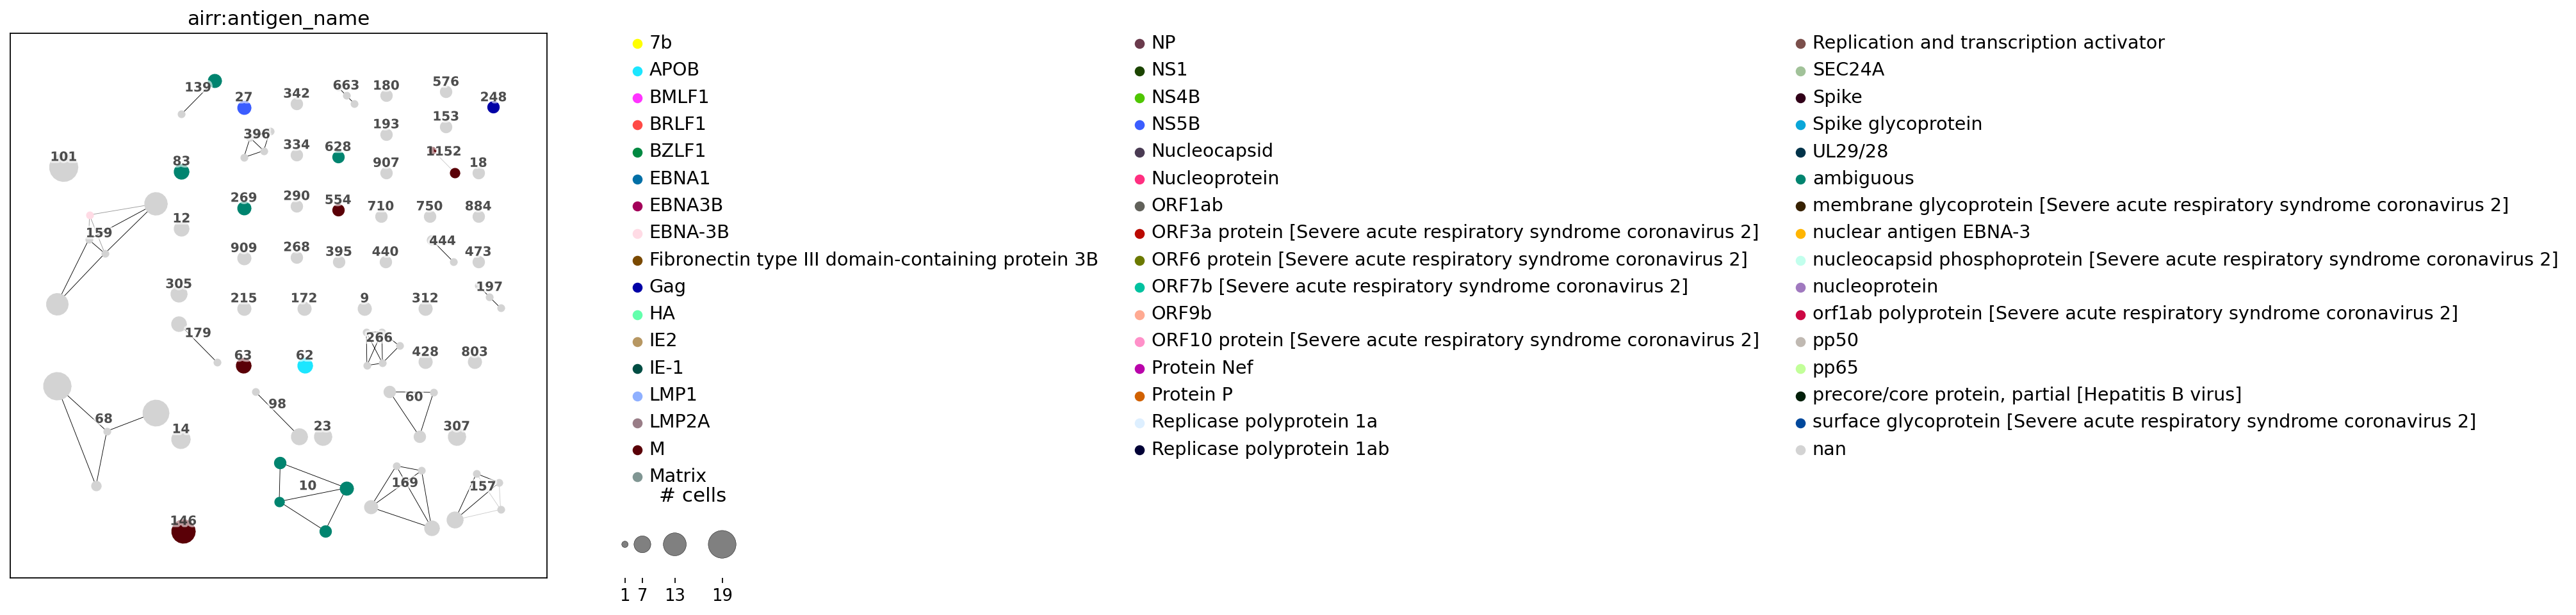

In [12]:
_=ir.pl.clonotype_network(mdata, color="airr:antigen_name", label_fontsize=9, panel_size=(7, 7), base_size=20)

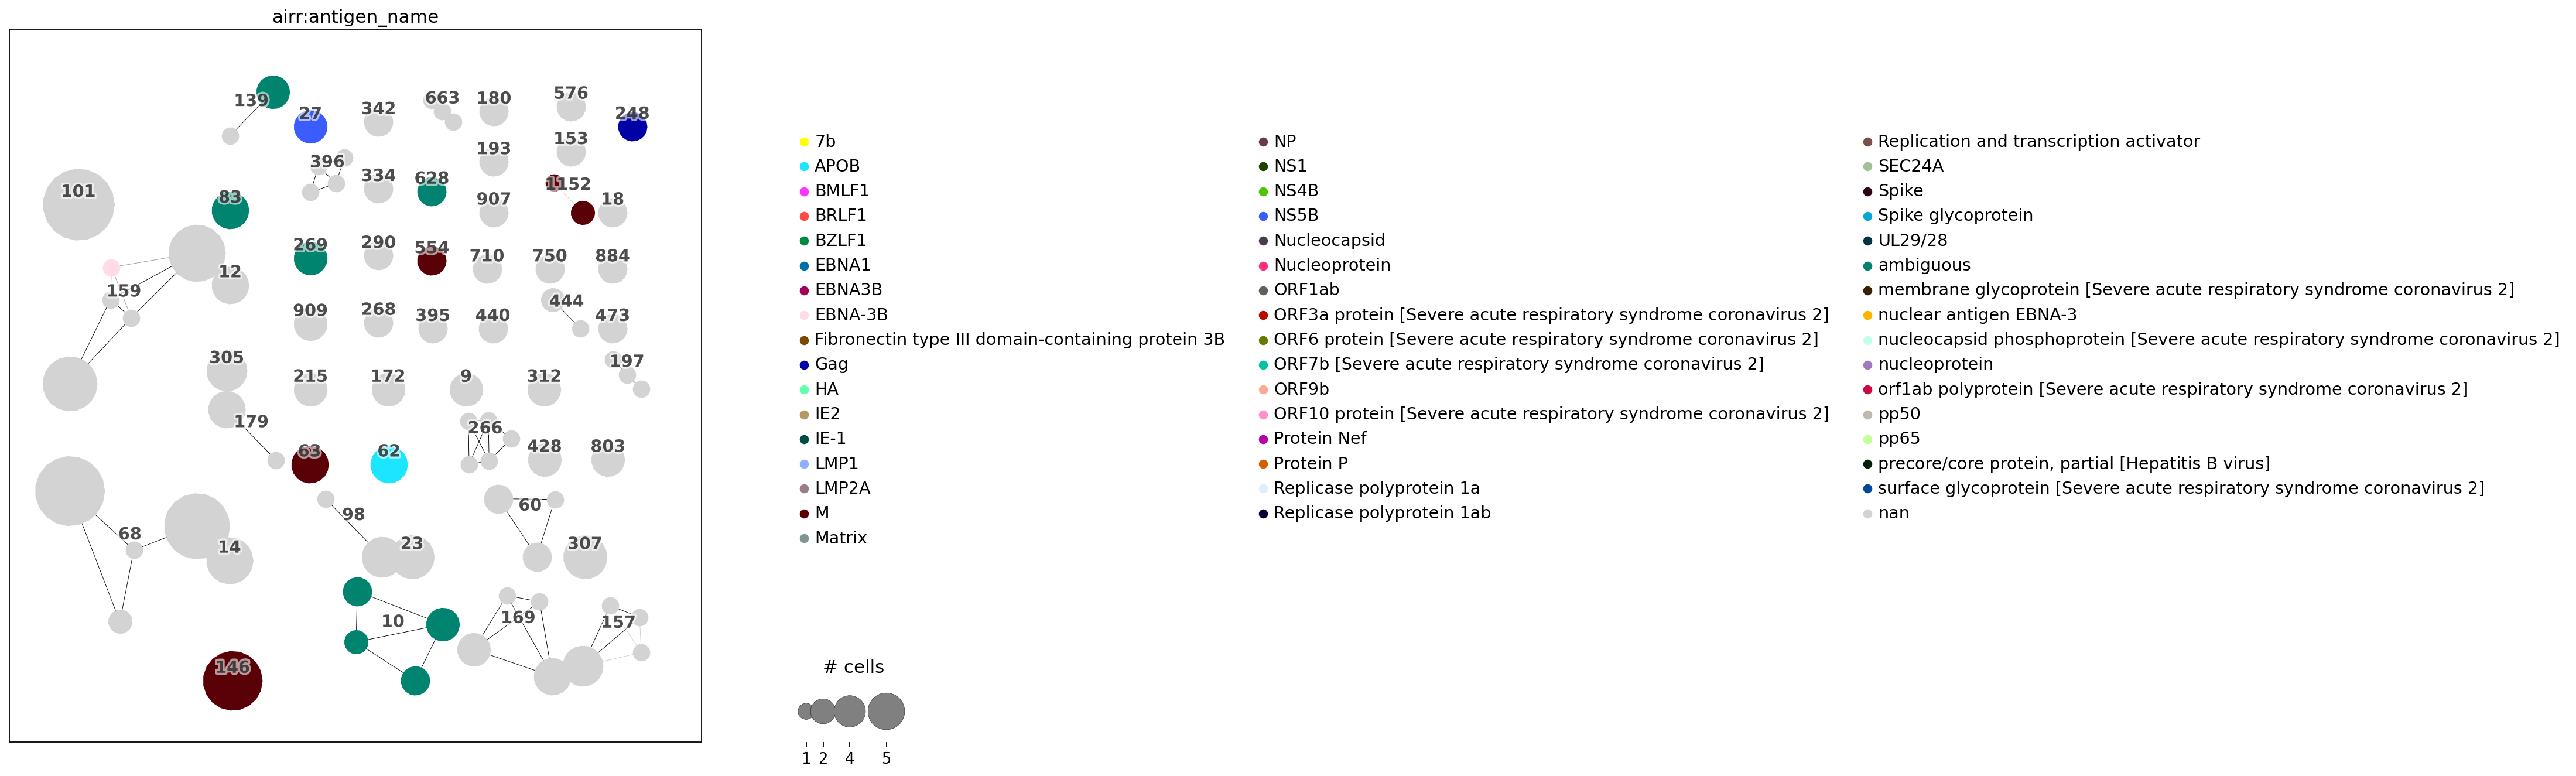

In [13]:
_=ir.pl.clonotype_network(mdata, color="airr:antigen_name", show_legend=True)

In [14]:
ir.tl.ir_query_annotate(
    mdata,
    adata,
    metric="fastalignment",
    sequence="aa",
    strategy = "most-frequent",
    include_ref_cols=["antigen_species"],
)

  0%|          | 0/289 [00:00<?, ?it/s]/home/lera/.cache/pypoetry/virtualenvs/tcr-epitope-cBadFBpD-py3.11/lib/python3.11/site-packages/scirpy/tl/_ir_query.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return values[0]
 76%|███████▋  | 221/289 [00:00<00:00, 1105.72it/s]

100%|██████████| 289/289 [00:00<00:00, 983.99it/s] 

Stored result in `mdata.obs["airr:antigen_species"]`.


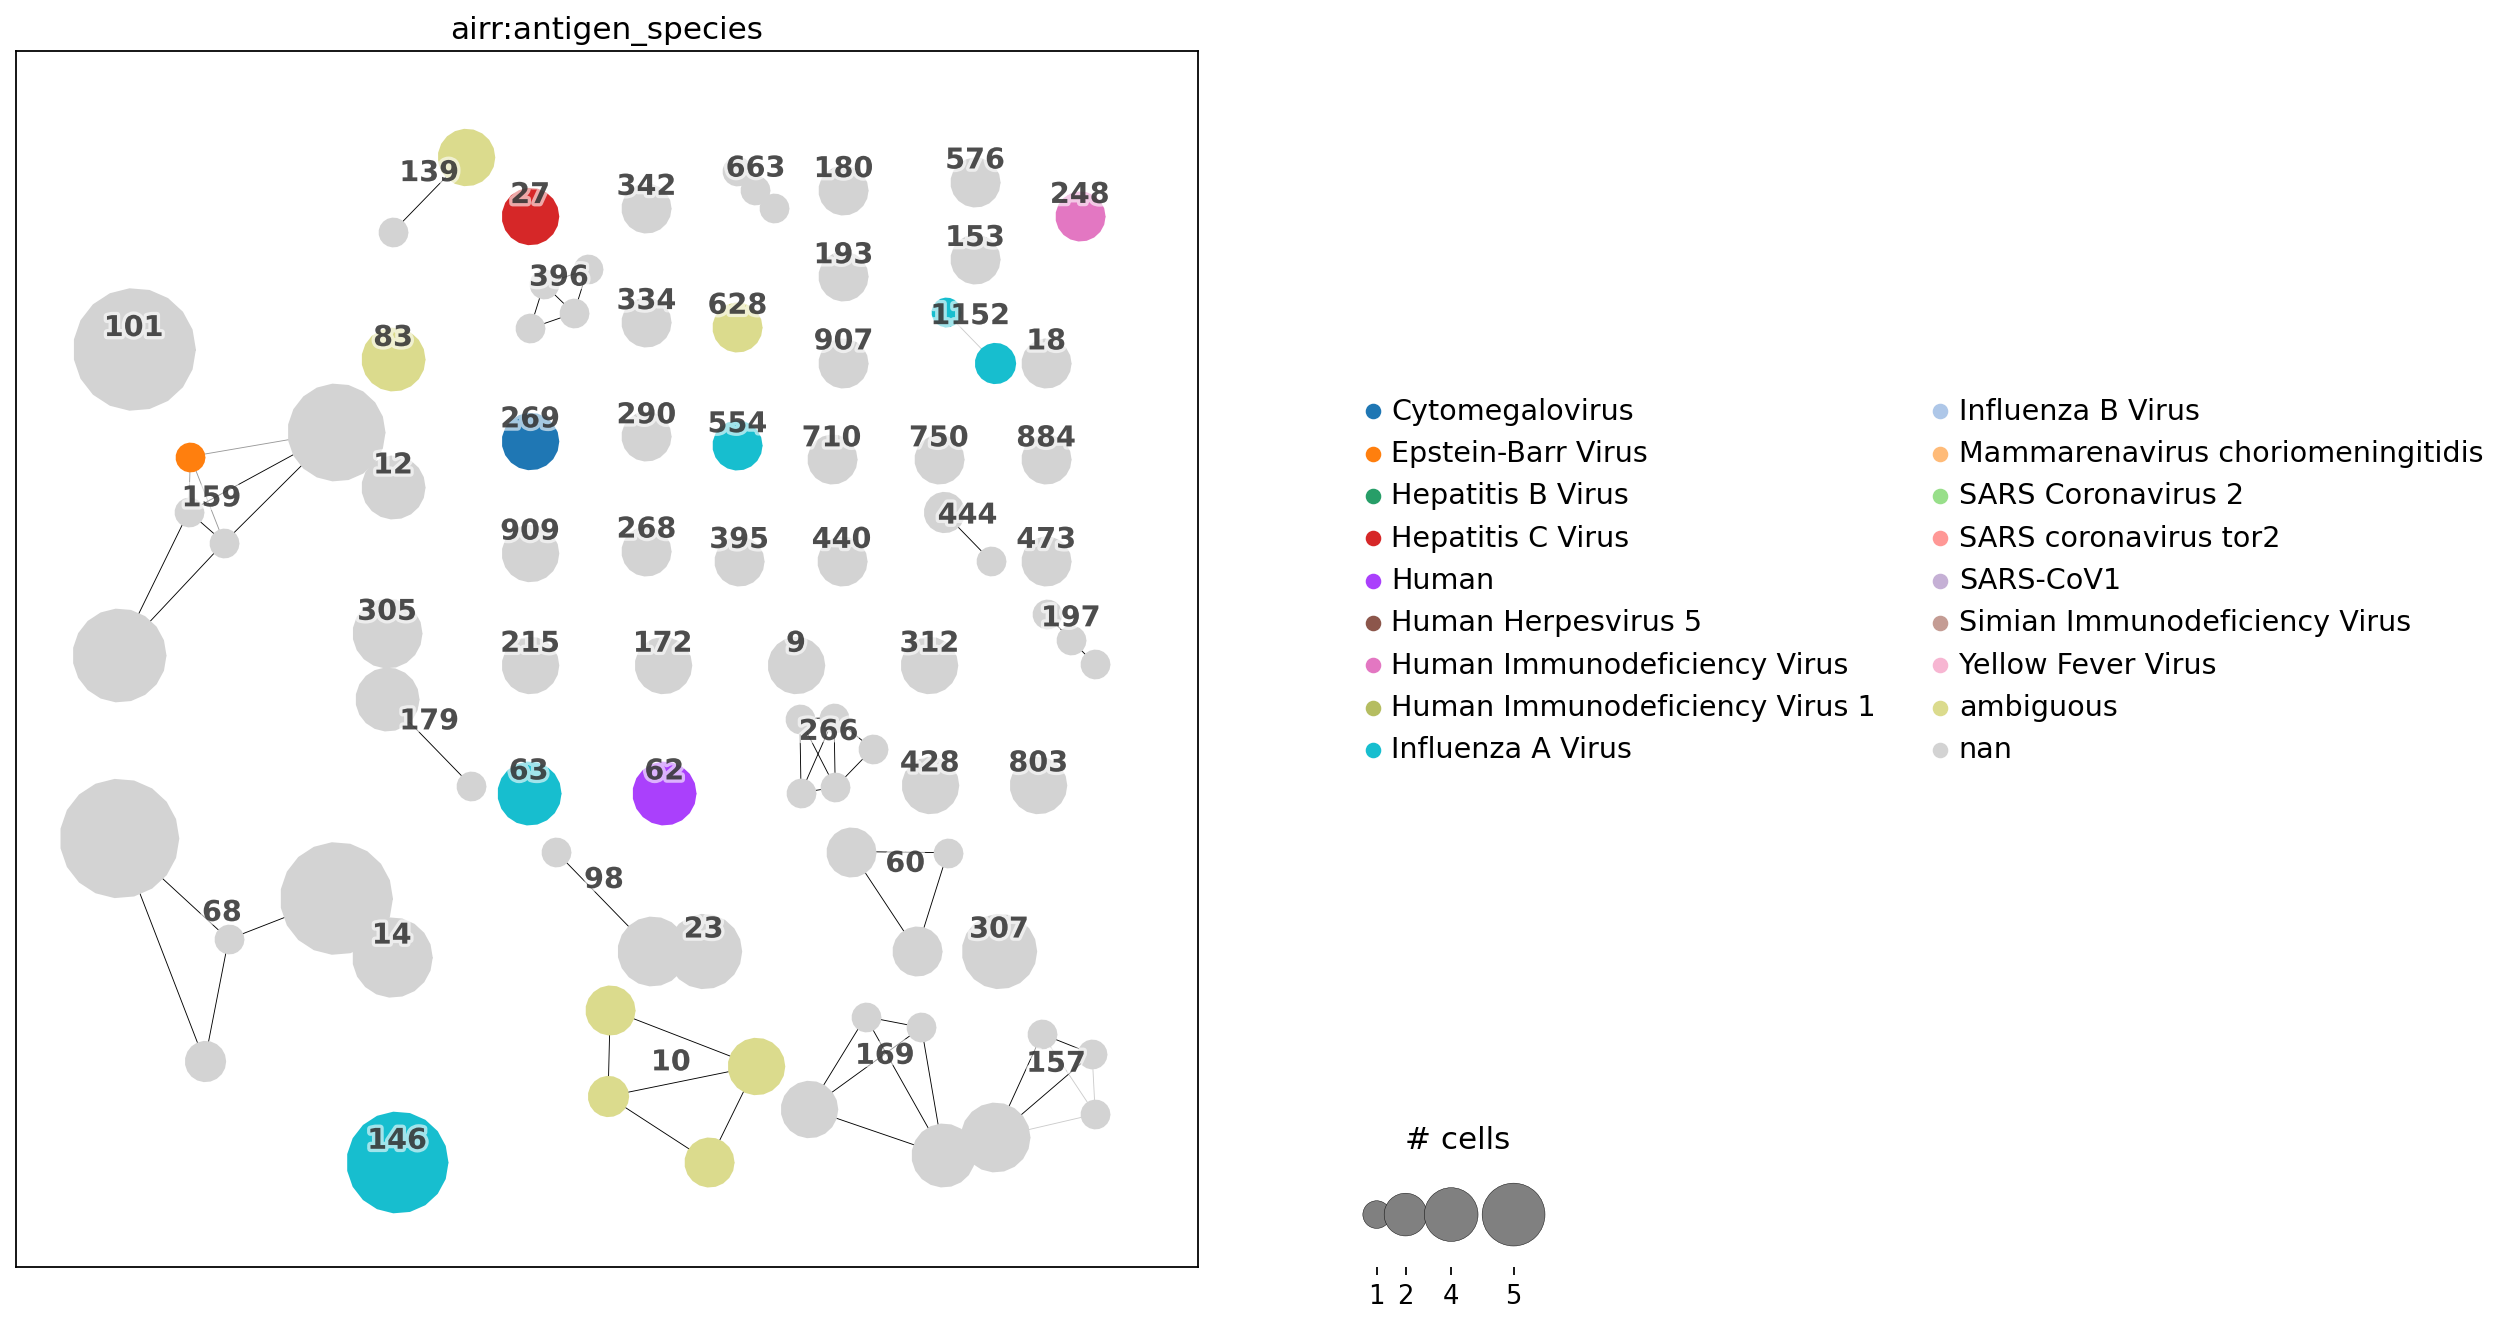

In [15]:
_=ir.pl.clonotype_network(mdata, color="airr:antigen_species", show_legend=True)